In [ ]:


!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 4.8 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15837, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 15837 (delta 30), reused 12 (delta 12), pack-reused 15781 (from 2)
Receiving objects: 100% (15837/15837), 6.40 MiB | 7.33 MiB/s, done.
Resolving deltas: 100% (11537/11537), done.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your en

In [ ]:


import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
torch:  2.6 ; cuda:  cu124
detectron2: 0.6


In [ ]:
r
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import os
import torch
from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import Visualizer
import cv2
import random
import matplotlib.pyplot as plt



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# from detectron2.data import MetadataCatalog, DatasetCatalog

# for d in ["coin_train", "coin_val", "coin_test"]:
#     if d in DatasetCatalog:
#         DatasetCatalog.remove(d)
#     if d in MetadataCatalog:
#         MetadataCatalog.remove(d)


### Dataset Registration and Sample Visualization

In this section,used to register the training, validation, and test datasets for coin segmentation using the COCO format via Detectron2’s `register_coco_instances` utility. Each dataset is linked to its corresponding image directory and annotation file. After registration,  fetch the training and validation metadata and dictionaries using Detectron2’s catalog system.

To ensure the data is correctly loaded and labeled, a visualize a few random samples from the training set has been plotted. Each image is overlaid with its corresponding annotations (bounding boxes and masks) using Detectron2’s `Visualizer`. This step is useful for verifying that the dataset img and label are correctly formatted before training the segmentation model.


In [ ]:

from detectron2.data.datasets import register_coco_instances
data_root = "/content/drive/MyDrive/hexcel/data"

register_coco_instances("coin_train", {}, f"{data_root}/train/train_fixed.json", f"{data_root}/train")
register_coco_instances("coin_val", {}, f"{data_root}/val/val_fixed.json", f"{data_root}/val")
register_coco_instances("coin_test", {}, f"{data_root}/test/test_fixed.json", f"{data_root}/test")



In [ ]:


train_metadata = MetadataCatalog.get("coin_train")
train_dataset_dicts = DatasetCatalog.get("coin_train")

[03/29 02:55:53 d2.data.datasets.coco]: Loading /content/drive/MyDrive/hexcel/data/train/train_fixed.json takes 1.12 seconds.
[03/29 02:55:53 d2.data.datasets.coco]: Loaded 13 images in COCO format from /content/drive/MyDrive/hexcel/data/train/train_fixed.json


In [ ]:


val_metadata = MetadataCatalog.get("coin_val")
val_dataset_dicts = DatasetCatalog.get("coin_val")

[03/29 02:55:57 d2.data.datasets.coco]: Loaded 3 images in COCO format from /content/drive/MyDrive/hexcel/data/val/val_fixed.json


In [ ]:
from matplotlib import pyplot as plt


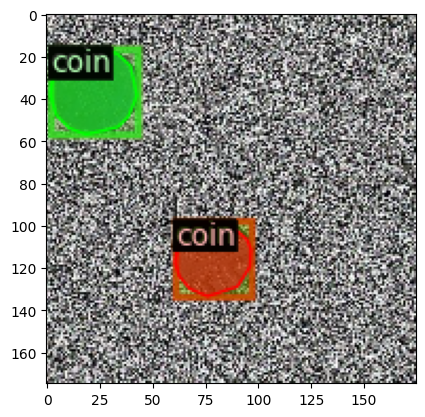

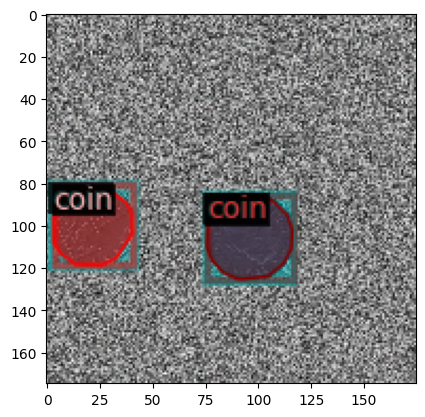

In [ ]:

# Visualize some random samples
for d in random.sample(train_dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

### Model Configuration and Training Setup

This section defines and initializes the training configuration for the coin segmentation model using Detectron2 and a Mask R-CNN backbone (`R_50_FPN_3x`). The following steps are performed:

- The COCO-pretrained Mask R-CNN model is used as a starting point by merging its default configuration.
- Custom datasets (`coin_train` and `coin_val`) are specified for training and validation.
- Essential training hyperparameters are set, including:
  - Batch size (`IMS_PER_BATCH = 2`)
  - Learning rate (`BASE_LR = 0.00025`)
  - Maximum iterations (`MAX_ITER = 500`)
  - RoI head parameters (`BATCH_SIZE_PER_IMAGE = 64`, `NUM_CLASSES = 1` for coin)
- The output directory is created for saving model checkpoints.
- Finally, a `DefaultTrainer` is initialized and training begins.

This setup ensures the model is fine-tuned on the custom coin segmentation dataset while leveraging pre-trained weights for improved performance and faster convergence.


In [ ]:
import numpy as np

In [ ]:

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = ("coin_train",)
cfg.DATASETS.TEST = ("coin_val",)
cfg.DATALOADER.NUM_WORKERS = 2

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 500
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1   #1 for coin

cfg.OUTPUT_DIR = "/content/drive/MyDrive/hexcel/models-seg/model_final.pth"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


In [ ]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


[03/29 02:56:22 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:00, 198MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[03/29 02:56:23 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[03/29 02:56:34 d2.utils.events]:  eta: 0:02:38  iter: 19  total_loss: 2.257  loss_cls: 0.6515  loss_box_reg: 0.8794  loss_mask: 0.6947  loss_rpn_cls: 0.01049  loss_rpn_loc: 0.01326    time: 0.3336  last_time: 0.2970  data_time: 0.0568  last_data_time: 0.0060   lr: 9.7405e-06  max_mem: 2247M
[03/29 02:56:45 d2.utils.events]:  eta: 0:02:33  iter: 39  total_loss: 2.16  loss_cls: 0.5679  loss_box_reg: 0.9052  loss_mask: 0.624  loss_rpn_cls: 0.01166  loss_rpn_loc: 0.01214    time: 0.3374  last_time: 0.3491  data_time: 0.0089  last_data_time: 0.0055   lr: 1.9731e-05  max_mem: 2247M
[03/29 02:56:51 d2.utils.events]:  eta: 0:02:25  iter: 59  total_loss: 1.894  loss_cls: 0.4728  loss_box_reg: 0.8811  loss_mask: 0.5145  loss_rpn_cls: 0.005062  loss_rpn_loc: 0.008951    time: 0.3325  last_time: 0.3038  data_time: 0.0087  last_data_time: 0.0032   lr: 2.972e-05  max_mem: 2247M
[03/29 02:56:58 d2.utils.events]:  eta: 0:02:19  iter: 79  total_loss: 1.688  loss_cls: 0.3853  loss_box_reg: 0.855  loss_

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader


evaluator = COCOEvaluator("coin_test", cfg, False, output_dir="/content/drive/MyDrive/hexcel/models-seg/model/")  #
val_loader = build_detection_test_loader(cfg, "coin_test")
print(inference_on_dataset(trainer.model, val_loader, evaluator))


### Inference and Coin Extraction from Full Images

This section performs inference using the trained Mask R-CNN segmentation model to detect coins in full, unprocessed images. The steps include:

1. **Model Loading**  
   The `DefaultPredictor` is initialized using the trained model weights, configured for one object class (coin) with a detection threshold of 0.5.

2. **Segmentation Inference and Cropping**  
   For each image in the input folder:
   - Coins are detected using instance segmentation.
   - Each coin is cropped based on its predicted mask and bounding box.
   - Non-coin background is masked out and replaced with a white background.
   - Cropped coins are resized to 224×224 pixels (matching classifier input requirements).
   - Each cropped coin is saved with a unique filename in the output directory.

3. **Qualitative Evaluation on Test Images**  
   A small number of test images are randomly sampled and visualized using the `Visualizer` utility from Detectron2.  
   Predicted masks and bounding boxes are overlaid on the original images to inspect model performance visually.

This process ensures that full images containing multiple coins are accurately segmented, extracted, and saved in a format compatible with  coin classification tasks.


In [ ]:
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

# path to your trained weights
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/hexcel/models-seg/model/model_final.pth"

# detection threshold
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

predictor = DefaultPredictor(cfg)


[03/30 18:06:29 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/hexcel/models-seg/model/model_final.pth ...


In [ ]:
import os
import cv2
import torch
import numpy as np
from tqdm import tqdm
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import ColorMode
from detectron2.data import MetadataCatalog


input_folder = "/content/drive/MyDrive/Hexcel_Company_Project/Input_Data_segmentation"  # Folder with original images
output_folder = "/content/drive/MyDrive/Hexcel_Company_Project/Output_Data_Masked"  # Save cropped coins here


resize_to = (224, 224)  # All crops will be resized to this
os.makedirs(output_folder, exist_ok=True)

image_list = [f for f in os.listdir(input_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

for img_name in tqdm(image_list):
    img_path = os.path.join(input_folder, img_name)
    image = cv2.imread(img_path)
    outputs = predictor(image)

    instances = outputs["instances"].to("cpu")
    masks = instances.pred_masks.numpy()
    boxes = instances.pred_boxes.tensor.numpy()
    scores = instances.scores.numpy()
    classes = instances.pred_classes.numpy()

    for i, mask in enumerate(masks):
        # Get bbox for cropping
        x1, y1, x2, y2 = boxes[i].astype(int)
        pad = 5
        x1, y1 = max(x1 - pad, 0), max(y1 - pad, 0)
        x2, y2 = min(x2 + pad, image.shape[1]), min(y2 + pad, image.shape[0])

        # Crop image + mask
        coin_img = image[y1:y2, x1:x2]
        coin_mask = mask[y1:y2, x1:x2].astype(np.uint8)

        # Apply white background where mask is 0
        bg = np.ones_like(coin_img) * 255  # white background
        coin_crop = np.where(coin_mask[:, :, None] == 1, coin_img, bg)

        # Resize to fixed square size (224x224)
        coin_resized = cv2.resize(coin_crop, resize_to, interpolation=cv2.INTER_AREA)

        # Save
        base_name = os.path.splitext(img_name)[0]
        filename = f"{base_name}_coin{i+1:03d}.png"
        out_path = os.path.join(output_folder, filename)
        cv2.imwrite(out_path, coin_resized) # Added this line to save the image

100%|██████████| 108/108 [00:33<00:00,  3.20it/s]


# Testing on unseen image

### Visual Inspection and Masked Coin Cropping from a Test Image

This section demonstrates two complementary approaches for evaluating the trained segmentation model on test data:

---

#### 1. Random Test Sample Visualization
- A few images are randomly sampled from the `coin_test` dataset.
- The trained Mask R-CNN model is used to predict coin instances.
- Using Detectron2’s `Visualizer`, predictions including masks and bounding boxes are drawn over the original images.
- These visualizations are displayed to qualitatively assess the model's segmentation performance.

---

#### 2. Masked Coin Extraction from a Single Test Image
- A specific test image (`coins102.png`) is processed to extract individual coin instances.
- Each coin is cropped using its predicted bounding box, and the background is replaced with white using the binary mask.
- An alpha (transparency) channel is added for visual clarity or further graphical processing.
- Each cropped coin is saved to disk with a filename containing:
  - The coin index
  - Predicted class name
  - Detection confidence score
- A visual preview of each extracted coin is shown for inspection.




[03/28 23:52:31 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
[03/28 23:52:31 d2.data.datasets.coco]: Loaded 2 images in COCO format from /content/drive/MyDrive/hexcel/data/test/test_fixed.json


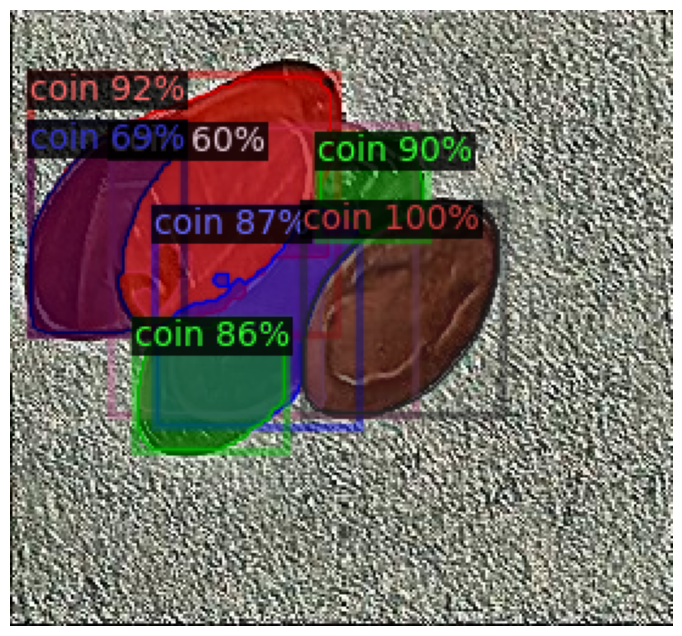

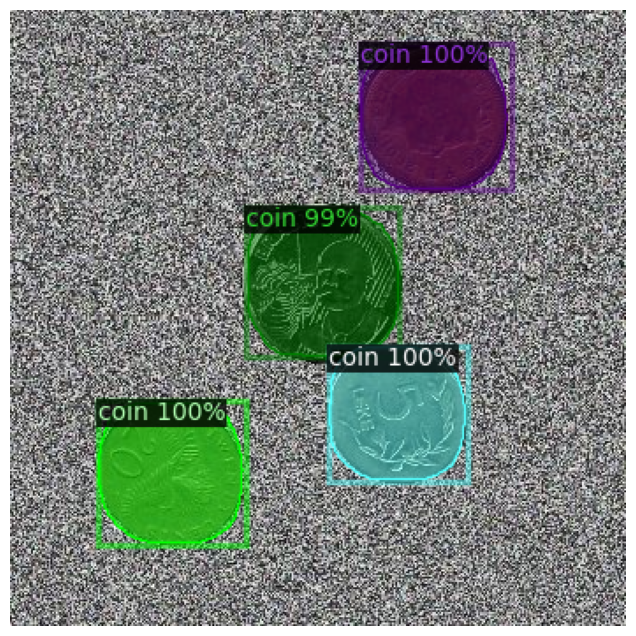

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)


dataset_dicts = DatasetCatalog.get("coin_test")
# get the number of samples in dataset_dicts
num_samples = len(dataset_dicts)
# ensure k is less than or equal to the number of samples
k = min(num_samples, 3)
for d in random.sample(dataset_dicts, k):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get("coin_test"), scale=1.0)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    plt.figure(figsize=(10, 8))
    plt.imshow(out.get_image())
    plt.axis('off')
    plt.show()



In [ ]:
import os
import cv2
import torch
import numpy as np
from matplotlib import pyplot as plt
from detectron2.utils.visualizer import Visualizer

In [ ]:
# Input image
test_img_path = "/content/drive/MyDrive/hexcel/coins102.png"
image = cv2.imread(test_img_path)
outputs = predictor(image)
instances = outputs["instances"].to("cpu")

In [ ]:

#  output folder
output_dir = "/content/cropped_coins_with_masks"
os.makedirs(output_dir, exist_ok=True)

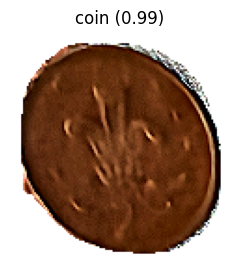

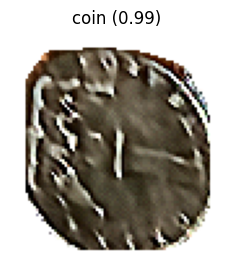

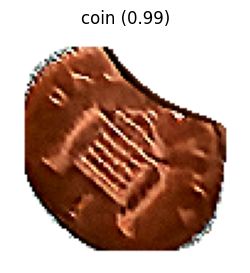

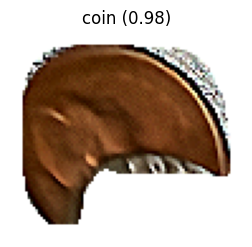

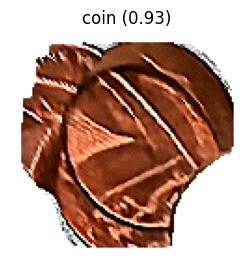

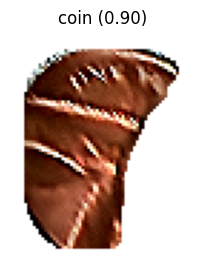

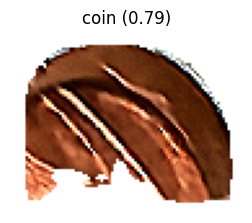

In [ ]:


# loop through instances
for i in range(len(instances)):
    mask = instances.pred_masks[i].numpy().astype(np.uint8)  # binary mask
    box = instances.pred_boxes.tensor[i].numpy().astype(int)
    score = instances.scores[i].item()
    class_id = instances.pred_classes[i].item()
    class_name = MetadataCatalog.get("coin_test").thing_classes[class_id]

    x1, y1, x2, y2 = box
    pad = 5
    x1, y1 = max(x1 - pad, 0), max(y1 - pad, 0)
    x2, y2 = min(x2 + pad, image.shape[1]), min(y2 + pad, image.shape[0])

    # Crop region from image and mask
    crop_img = image[y1:y2, x1:x2]
    crop_mask = mask[y1:y2, x1:x2]

    # apply mask to crop: set background to white
    masked_crop = crop_img.copy()
    masked_crop[~crop_mask.astype(bool)] = (255, 255, 255)  # white background

    # apply transparency (alpha channel)
    crop_rgba = cv2.cvtColor(masked_crop, cv2.COLOR_BGR2BGRA)
    crop_rgba[:, :, 3] = crop_mask * 255  # alpha = mask

    # Save result
    filename = f"coin_{i+1:03d}_{class_name}_{score:.2f}.png"
    out_path = os.path.join(output_dir, filename)
    cv2.imwrite(out_path, crop_rgba)

    # show the result
    plt.figure(figsize=(3, 3))
    plt.imshow(cv2.cvtColor(masked_crop, cv2.COLOR_BGR2RGB))
    plt.title(f"{class_name} ({score:.2f})")
    plt.axis('off')
    plt.show()
